In [34]:
import os
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, RobertaModel, RobertaTokenizer
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import re
import copy
import pprint
import time

MAX_NO_OF_SPEAKERS = 8
MAX_DIALOGUE_LEN   = 33
original_labels    = ['abuse', 'adoration', 'annoyance', 'awkwardness', 'benefit', 'boredom', 'calmness', 'challenge', 'cheer', 'confusion', 'curiosity', 'desire', 'excitement', 'guilt', 'horror', 'humour', 'impressed', 'loss', 'nervousness', 'nostalgia', 'pain', 'relief', 'satisfaction', 'scold', 'shock', 'sympathy', 'threat']
train_count        = [31, 190, 1051, 880, 220, 78, 752, 214, 534, 486, 545, 180, 867, 216, 280, 153, 257, 351, 398, 65, 36, 173, 136, 94, 372, 209, 263]

EMOTIONS           = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

sent_model = 'roberta-base-nli-stsb-mean-tokens'

print('tr version', transformers.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device => ",device, ' torch ', torch.__version__)

tr version 4.35.1
Using device =>  cpu  torch  2.1.0+cu121


In [13]:
class EmotionClassifier(nn.Module):
    def __init__(self, n_classes):
        super(EmotionClassifier, self).__init__()
        self.bert = RobertaModel.from_pretrained('roberta-base')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        op = self.bert(input_ids=input_ids,attention_mask=attention_mask)
        output = self.drop(op[1])
        return self.out(output), op[1]

# load finetuned roberta model
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_finetuned = EmotionClassifier(7).to(device)
#roberta_tf_checkpoint = torch.load('dump_files/finetuned/best_model_state_roberta.bin', map_location=torch.device(device))
#roberta_finetuned.load_state_dict(roberta_tf_checkpoint)
print('model loaded')


# Helper functions



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model loaded


In [14]:
train_csv = pd.read_json("EDiReF-Train-Data/Task 3/MELD_train_efr.json")

In [15]:
train_df = pd.DataFrame(train_csv)
train_df

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...,...
3995,utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3996,utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3997,utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3998,utterance_3998,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
print(train_df['emotions'][0], train_df['speakers'][0])

['neutral', 'neutral', 'neutral', 'neutral', 'surprise'] ['Chandler', 'The Interviewer', 'Chandler', 'The Interviewer', 'Chandler']


In [17]:
dummies = pd.get_dummies(EMOTIONS)
dummies['anger']

0     True
1    False
2    False
3    False
4    False
5    False
6    False
Name: anger, dtype: bool

In [18]:
listaEmo = []
for i in train_df['emotions']:
    listtemp = []
    for j in i:
        listtemp.append(dummies[j])
    listaEmo.append(listtemp)

In [19]:
train_df['emotions'] = listaEmo
train_df

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[[False, False, False, False, True, False, Fal...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[[False, False, False, False, True, False, Fal...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[[False, False, False, False, True, False, Fal...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[[False, False, False, False, True, False, Fal...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[[False, False, False, False, False, False, Tr...",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...,...
3995,utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[[False, False, False, False, True, False, Fal...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3996,utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[[False, False, False, False, True, False, Fal...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3997,utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[[False, False, False, False, True, False, Fal...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3998,utterance_3998,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[[False, False, False, False, True, False, Fal...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [20]:
train_df['speakers']

0       [Chandler, The Interviewer, Chandler, The Inte...
1       [Chandler, The Interviewer, Chandler, The Inte...
2       [Chandler, The Interviewer, Chandler, The Inte...
3       [Chandler, The Interviewer, Chandler, The Inte...
4                            [Joey, Rachel, Joey, Rachel]
                              ...                        
3995    [Chandler, All, Monica, Chandler, Ross, Chandl...
3996    [Chandler, All, Monica, Chandler, Ross, Chandl...
3997    [Chandler, All, Monica, Chandler, Ross, Chandl...
3998    [Chandler, All, Monica, Chandler, Ross, Chandl...
3999    [Chandler, All, Monica, Chandler, Ross, Chandl...
Name: speakers, Length: 4000, dtype: object

In [21]:
listSpk = []
for i in train_df['speakers']:
    dic = {}
    tempskp = []
    count = 0
    for speaker in i:
        if speaker not in dic:
            count = count + 1
            dic[speaker] = count
        tempskp.append(dic[speaker])
    listSpk.append(tempskp)

In [22]:
train_df['speakers'] = listSpk
train_df['speakers']

0                                         [1, 2, 1, 2, 1]
1                                   [1, 2, 1, 2, 1, 2, 1]
2                       [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1]
3                 [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1]
4                                            [1, 2, 1, 2]
                              ...                        
3995                 [1, 2, 3, 1, 4, 1, 5, 1, 3, 6, 6, 6]
3996           [1, 2, 3, 1, 4, 1, 5, 1, 3, 6, 6, 6, 6, 1]
3997        [1, 2, 3, 1, 4, 1, 5, 1, 3, 6, 6, 6, 6, 1, 4]
3998     [1, 2, 3, 1, 4, 1, 5, 1, 3, 6, 6, 6, 6, 1, 4, 6]
3999    [1, 2, 3, 1, 4, 1, 5, 1, 3, 6, 6, 6, 6, 1, 4, ...
Name: speakers, Length: 4000, dtype: object

In [23]:
i = 0
sentence_embeddings = []
    # sent_emb = model.encode('')
while i < len(train_df):
    utt = train_df['utterances'][i]
    encodings = roberta_tokenizer.encode_plus(utt, max_length=100, padding = 'max_length', add_special_tokens=True, return_token_type_ids=True, return_attention_mask=True, truncation=True, return_tensors='pt').to(device)
    utt_emb = roberta_finetuned(encodings['input_ids'], encodings['attention_mask'])[1].detach().tolist()[0]
    utt_emb = np.round(utt_emb, decimals = 10)
    # utt_emb = model.encode(utt)
    sent_emb = utt_emb
    i += 1
    sentence_embeddings.append(copy.deepcopy(sent_emb))


In [24]:
train_df['sentence_embeddings'] = sentence_embeddings
df_sent = pd.DataFrame(sentence_embeddings)

In [25]:
csvread = pd.read_csv("./EDiReF-Train-Data/Task 3/out.csv",names=["Valence", "Arousal", "Dominance"])
print(csvread)

           Valence  Arousal  Dominance
aaaaaaah     0.479    0.606      0.291
aaaah        0.520    0.636      0.282
aardvark     0.427    0.490      0.437
aback        0.385    0.407      0.288
abacus       0.510    0.276      0.485
...            ...      ...        ...
zoo          0.760    0.520      0.580
zoological   0.667    0.458      0.492
zoology      0.568    0.347      0.509
zoom         0.490    0.520      0.462
zucchini     0.510    0.321      0.250

[19971 rows x 3 columns]


In [26]:
import re
from collections import defaultdict

track = defaultdict(list)

for i in train_df['utterances']:
    for sentence in i:
        sentence = sentence.lower().split()
        for word in sentence:
            cleaned_word = re.sub(r'[^a-zA-Z]', '', word)
            if cleaned_word in csvread.index and cleaned_word not in track:
                track[cleaned_word].append(csvread['Valence'][cleaned_word])
                track[cleaned_word].append(csvread['Arousal'][cleaned_word])
                track[cleaned_word].append(csvread['Dominance'][cleaned_word])
                

# Ahora, track contendrá las palabras limpias como claves y listas de diccionarios como valores, 
# donde cada diccionario contiene las propiedades Valence, Arousal y Dominance para esa palabra.


In [27]:
track

defaultdict(list,
            {'point': ['0.490', 0.193, 0.431],
             'person': ['0.646', 0.363, 0.596],
             'transition': ['0.605', 0.561, 0.558],
             'system': ['0.615', 0.346, 0.764],
             'full': ['0.602', 0.255, 0.704],
             'talk': ['0.833', 0.346, 0.594],
             'little': ['0.385', 0.16, 0.213],
             'bit': ['0.427', 0.31, 0.225],
             'right': ['0.740', 0.352, 0.71],
             'be': ['0.670', 0.24, 0.554],
             'heading': ['0.551', 0.292, 0.642],
             'whole': ['0.653', 0.357, 0.572],
             'division': ['0.370', 0.481, 0.472],
             'have': ['0.757', 0.389, 0.593],
             'lot': ['0.531', 0.215, 0.37],
             'see': ['0.635', 0.269, 0.312],
             'people': ['0.604', 0.4, 0.5],
             'can': ['0.662', 0.36, 0.454],
             'dump': ['0.345', 0.5, 0.37],
             'certain': ['0.760', 0.358, 0.673],
             'amount': ['0.562', 0.422, 0.649],
      

In [28]:
valen = []
aros = []
domi = []
for i in train_df['utterances']:
    listVal = []
    listAro = []
    listDom = []
    for sentence in i:
        valence_sen = []
        arousal_sen = []
        dominance_sen = []
        sentence = sentence.lower().split()
        for word in sentence:
            cleaned_word = re.sub(r'[^a-zA-Z]', '', word)
            if cleaned_word in track:
                val, aro, dom = track[cleaned_word]
                valence_sen.append(float(val))
                arousal_sen.append(float(aro))
                dominance_sen.append(float(dom))
            else:
                valence_sen.append(0)
                arousal_sen.append(0)
                dominance_sen.append(0)
        listVal.append(valence_sen)
        listAro.append(arousal_sen)
        listDom.append(dominance_sen)
    valen.append(listVal)
    aros.append(listAro)
    domi.append(listDom)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4000,) + inhomogeneous part.

In [39]:
meanT = []
for i in valen:
    mean = []
    for j in i:
        mean.append(np.mean(j))
    meanT.append(mean)

In [40]:
print(valen[3999])
train_df['utterances'][3999]

[[0], [0], [0, 0, 0, 0], [0, 0.245, 0, 0, 0], [0, 0.551, 0, 0, 0, 0, 0.802, 0.396, 0.449], [0, 0, 0.573, 0, 0, 0, 0, 0, 0, 0, 0], [0.529, 0, 0, 0, 0, 0, 0.573], [0, 0, 0, 0, 0.57, 0.438, 0, 0, 0.635, 0, 0.667], [0, 0, 0, 0.823, 0, 0, 0, 0, 0.06, 0, 0, 0, 0.357, 0.083, 0.519], [0.448, 0, 0.448, 0], [0, 0, 0.439, 0, 0.51, 0, 0, 0.542], [0, 0, 0.625, 0, 0, 0, 0.847, 0, 0, 0, 0, 0.806, 0, 0.49, 0, 0, 0, 0, 0.49, 0.958, 0.844, 0, 0, 0, 0, 0, 0, 0.811], [0, 0, 0, 0.594], [0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.757, 0, 0], [0, 0, 0, 0, 0, 0, 0.74], [0]]


['Hey.',
 'Hey!',
 'So how was Joan?',
 'I broke up with her.',
 "Don't tell me, because of the big nostril thing?",
 'They were huge. When she sneezed, bats flew out of them.',
 'Come on, they were not that huge.',
 "I'm tellin' you, she leaned back; I could see her brain.",
 'How many perfectly fine women are you gonna reject over the most superficial insignificant things?',
 'Hold it, hold it.',
 'I gotta side with Chandler on this one.',
 "When I first moved to the city, I went out a couple of times with this girl, really hot, great kisser, but she had the biggest Adam's apple.",
 'It made me nuts.',
 'You or me?',
 "I got it. Uh, Joey, women don't have Adam's apples.",
 'You guys are messing with me, right?',
 'Yeah.']

In [41]:
train_df['valence'] = meanT

In [42]:
nanlist = np.full(len(meanT[0]), np.nan)
nanlist[2] = 5
nanlist

array([nan, nan,  5., nan, nan])

In [44]:
import copy
lista = []

for i in range(len(train_df['speakers'])):
    diccionario = {}
    nanlist = np.full(len(meanT[i]), np.nan)
    
    for j, speaker in enumerate(train_df['speakers'][i]):
        if speaker in diccionario:
            diccionario[speaker][j] = meanT[i][j]
        else:
            nanlist_copy = copy.copy(nanlist)  # Crea una copia independiente de nanlist
            nanlist_copy[j] = meanT[i][j]
            diccionario[speaker] = nanlist_copy

    lista.append(list(diccionario.values()))



In [45]:
replaced_valance = [np.nan_to_num(x, nan=-1) for x in lista]
train_df['valence_speaker']=replaced_valance

In [46]:
train_df['valence_speaker'][174]

array([[ 0.19283333, -1.        ,  0.412875  , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        ,  0.14285714,
        -1.        ,  0.255     , -1.        , -1.        ],
       [-1.        ,  0.501125  , -1.        , -1.        , -1.        ,
         0.        , -1.        ,  0.170125  , -1.        , -1.        ,
         0.        , -1.        , -1.        ,  0.32129412],
       [-1.        , -1.        , -1.        ,  0.1855    , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        ,  0.27875   ,
        -1.        ,  0.40166667, -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ,  0.4185    , -1.        ,
        -1.        , -1.  

In [47]:
train_df

,episode,speakers,emotions,utterances,triggers,sentence_embeddings,valence,valence_speaker
0,utterance_0,"[1, 2, 1, 2, 1]","[[False, False, False, False, True, False, Fal...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]","[0.0154345334, 0.1910427213, -0.1446124464, 0....","[0.14725, 0.10033333333333333, 0.0, 0.18277777...","[[0.14725, -1.0, 0.0, -1.0, 0.185], [-1.0, 0.1..."
1,utterance_1,"[1, 2, 1, 2, 1, 2, 1]","[[False, False, False, False, True, False, Fal...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0137472358, 0.173657611, -0.1451763064, 0.1...","[0.14725, 0.10033333333333333, 0.0, 0.18277777...","[[0.14725, -1.0, 0.0, -1.0, 0.185, -1.0, 0.317..."
2,utterance_2,"[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1]","[[False, False, False, False, True, False, Fal...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0132562984, 0.1341271251, -0.1495521367, 0....","[0.14725, 0.10033333333333333, 0.0, 0.18277777...","[[0.14725, -1.0, 0.0, -1.0, 0.185, -1.0, 0.317..."
3,utterance_3,"[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1]","[[False, False, False, False, True, False, Fal...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0091593927, 0.1393967271, -0.1447667778, 0....","[0.14725, 0.10033333333333333, 0.0, 0.18277777...","[[0.14725, -1.0, 0.0, -1.0, 0.185, -1.0, 0.317..."
4,utterance_4,"[1, 2, 1, 2]","[[False, False, False, False, False, False, Tr...",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]","[0.0270308554, 0.1875266433, -0.1426392645, 0....","[0.12127272727272728, 0.26925, 0.0, 0.10928571...","[[0.12127272727272728, -1.0, 0.0, -1.0], [-1.0..."
...,...,...,...,...,...,...,...,...
3995,utterance_3995,"[1, 2, 3, 1, 4, 1, 5, 1, 3, 6, 6, 6]","[[False, False, False, False, True, False, Fal...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0127896583, 0.1395556927, -0.1457487643, 0....","[0.0, 0.0, 0.0, 0.049, 0.24422222222222223, 0....","[[0.0, -1.0, -1.0, 0.049, -1.0, 0.052090909090..."
3996,utterance_3996,"[1, 2, 3, 1, 4, 1, 5, 1, 3, 6, 6, 6, 6, 1]","[[False, False, False, False, True, False, Fal...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0054899799, 0.1387219727, -0.1431471705, 0....","[0.0, 0.0, 0.0, 0.049, 0.24422222222222223, 0....","[[0.0, -1.0, -1.0, 0.049, -1.0, 0.052090909090..."
3997,utterance_3997,"[1, 2, 3, 1, 4, 1, 5, 1, 3, 6, 6, 6, 6, 1, 4]","[[False, False, False, False, True, False, Fal...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0006412248, 0.1379950494, -0.1410688758, 0....","[0.0, 0.0, 0.0, 0.049, 0.24422222222222223, 0....","[[0.0, -1.0, -1.0, 0.049, -1.0, 0.052090909090..."
3998,utterance_3998,"[1, 2, 3, 1, 4, 1, 5, 1, 3, 6, 6, 6, 6, 1, 4, 6]","[[False, False, False, False, True, False, Fal...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0025664978, 0.1363260895, -0.1433342695, 0....","[0.0, 0.0, 0.0, 0.049, 0.24422222222222223, 0....","[[0.0, -1.0, -1.0, 0.049, -1.0, 0.052090909090..."


In [63]:
with open('train_df.pkl', 'wb') as file:
    pickle.dump(train_df, file)

In [65]:
with open('train_df.pkl', 'rb') as file:
    train_df = pickle.load(file)
train_df

,episode,speakers,emotions,utterances,triggers,sentence_embeddings,valence,valence_speaker
0,utterance_0,"[1, 2, 1, 2, 1]","[[False, False, False, False, True, False, Fal...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]","[0.0154345334, 0.1910427213, -0.1446124464, 0....","[0.14725, 0.10033333333333333, 0.0, 0.18277777...","[[0.14725, -1.0, 0.0, -1.0, 0.185], [-1.0, 0.1..."
1,utterance_1,"[1, 2, 1, 2, 1, 2, 1]","[[False, False, False, False, True, False, Fal...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0137472358, 0.173657611, -0.1451763064, 0.1...","[0.14725, 0.10033333333333333, 0.0, 0.18277777...","[[0.14725, -1.0, 0.0, -1.0, 0.185, -1.0, 0.317..."
2,utterance_2,"[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1]","[[False, False, False, False, True, False, Fal...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0132562984, 0.1341271251, -0.1495521367, 0....","[0.14725, 0.10033333333333333, 0.0, 0.18277777...","[[0.14725, -1.0, 0.0, -1.0, 0.185, -1.0, 0.317..."
3,utterance_3,"[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1]","[[False, False, False, False, True, False, Fal...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0091593927, 0.1393967271, -0.1447667778, 0....","[0.14725, 0.10033333333333333, 0.0, 0.18277777...","[[0.14725, -1.0, 0.0, -1.0, 0.185, -1.0, 0.317..."
4,utterance_4,"[1, 2, 1, 2]","[[False, False, False, False, False, False, Tr...",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]","[0.0270308554, 0.1875266433, -0.1426392645, 0....","[0.12127272727272728, 0.26925, 0.0, 0.10928571...","[[0.12127272727272728, -1.0, 0.0, -1.0], [-1.0..."
...,...,...,...,...,...,...,...,...
3995,utterance_3995,"[1, 2, 3, 1, 4, 1, 5, 1, 3, 6, 6, 6]","[[False, False, False, False, True, False, Fal...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0127896583, 0.1395556927, -0.1457487643, 0....","[0.0, 0.0, 0.0, 0.049, 0.24422222222222223, 0....","[[0.0, -1.0, -1.0, 0.049, -1.0, 0.052090909090..."
3996,utterance_3996,"[1, 2, 3, 1, 4, 1, 5, 1, 3, 6, 6, 6, 6, 1]","[[False, False, False, False, True, False, Fal...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0054899799, 0.1387219727, -0.1431471705, 0....","[0.0, 0.0, 0.0, 0.049, 0.24422222222222223, 0....","[[0.0, -1.0, -1.0, 0.049, -1.0, 0.052090909090..."
3997,utterance_3997,"[1, 2, 3, 1, 4, 1, 5, 1, 3, 6, 6, 6, 6, 1, 4]","[[False, False, False, False, True, False, Fal...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0006412248, 0.1379950494, -0.1410688758, 0....","[0.0, 0.0, 0.0, 0.049, 0.24422222222222223, 0....","[[0.0, -1.0, -1.0, 0.049, -1.0, 0.052090909090..."
3998,utterance_3998,"[1, 2, 3, 1, 4, 1, 5, 1, 3, 6, 6, 6, 6, 1, 4, 6]","[[False, False, False, False, True, False, Fal...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0025664978, 0.1363260895, -0.1433342695, 0....","[0.0, 0.0, 0.0, 0.049, 0.24422222222222223, 0....","[[0.0, -1.0, -1.0, 0.049, -1.0, 0.052090909090..."


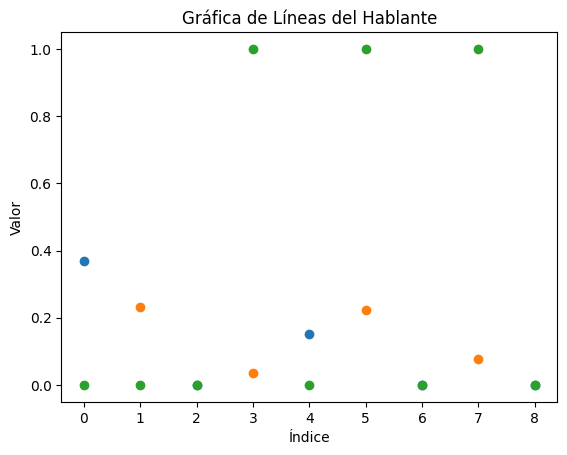

[0.37      nan 0.        nan 0.1516    nan 0.        nan 0.    ] [       nan 0.23077778        nan 0.035             nan 0.22314286
        nan 0.0786            nan]


In [51]:
import matplotlib.pyplot as plt

i = 62
# Elegir un hablante específico y sus valores
speaker1_data = lista[i][0]
speaker2_data = lista[i][1]
# Crear una secuencia de índices para el eje x
x = train_df['triggers'][i]

# Crear una gráfica de líneas
plt.scatter( [i for i,x in enumerate(speaker1_data)],speaker1_data)
plt.scatter( [i for i,x in enumerate(speaker2_data)],speaker2_data)
plt.scatter( [i for i,x in enumerate(x)],x)
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Gráfica de Líneas del Hablante')

# Mostrar la gráfica
plt.show()
print(speaker1_data, speaker2_data)


In [52]:
class SemEvalDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.len = len(self.data)
        print(list(train_df.columns))
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        dict_x = {}
        dict_x['speaker'] = torch.tensor(self.data['speakers'][index], dtype=torch.int)
        dict_x['emotion'] = torch.tensor(self.data['emotions'][index], dtype=torch.int)
        dict_x['sentence_embeddings'] = torch.tensor(self.data['sentence_embeddings'][index], dtype=torch.float64)
        dict_x['valence'] = torch.tensor(self.data['valence'][index])

        dict_y = {}
        dict_y['triggers'] =  torch.tensor(self.data['triggers'][index], dtype=torch.float32)

        return dict_x, dict_y

In [53]:
train_dataset = SemEvalDataset(train_df)

['episode', 'speakers', 'emotions', 'utterances', 'triggers', 'sentence_embeddings', 'valence', 'valence_speaker']


In [54]:
train_df['valence'][9]

[0.0, 0.125, 0.22333333333333336, 0.10114285714285713, 0.24]

In [55]:
train_dataset.__getitem__(9)

({'speaker': tensor([1, 2, 1, 2, 1], dtype=torch.int32),
  'emotion': tensor([[0, 0, 0, 0, 1, 0, 0],
          [0, 0, 0, 0, 1, 0, 0],
          [0, 0, 0, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 1, 0],
          [0, 0, 0, 0, 0, 0, 1]], dtype=torch.int32),
  'sentence_embeddings': tensor([ 1.5435e-02,  1.9104e-01, -1.4461e-01,  1.5656e-01, -1.1302e-01,
           2.6897e-02,  3.4963e-01, -2.1497e-01, -2.7194e-01, -2.6170e-01,
           2.2691e-01,  2.5571e-01,  5.7965e-02, -2.9037e-01, -2.5372e-03,
          -1.6026e-01, -1.2177e-01, -2.8106e-01,  5.8836e-03,  3.4815e-02,
          -2.1617e-01, -4.5411e-01,  3.4106e-01, -8.1185e-02, -8.4146e-02,
           4.2784e-02,  1.8614e-01, -2.0929e-01, -3.5972e-02,  6.6583e-02,
          -5.6148e-01,  2.4411e-01, -5.5350e-01,  1.2666e-01,  1.6421e-01,
           1.8861e-01, -2.6305e-01,  2.7630e-03, -1.4858e-01, -1.5705e-01,
          -1.7093e-01,  3.0128e-01,  7.3719e-02,  3.1914e-01, -4.6498e-01,
          -1.6019e-01, -1.9618e-01,  4.6836e-02,

In [56]:
class MELDCollate:
    def __init__(self, pad_value = 0):
        self.pad_value = pad_value
    def __call__(self, batch):
        speaker             = pad_sequence([item[0]['speaker'] for item in batch], batch_first = True)
        emotion             = pad_sequence([item[0]['emotion'] for item in batch], batch_first = True)
        sentence_embeddings = pad_sequence([item[0]['sentence_embeddings'] for item in batch], batch_first = True)
        valence             = pad_sequence([item[0]['valence'] for item in batch], batch_first = True)
        # print('\noriginal list : ',[item[0]['speaker'] for item in batch], '\n\npadded list : ', speaker)
        labels              = pad_sequence([item[1]['triggers'] for item in batch], batch_first = True)

        dict_x = { 'speaker': speaker, 'emotion':emotion,  'sentence_embeddings':sentence_embeddings, 'valence':valence}
        dict_y = {'labels': labels}

        return dict_x, dict_y

In [57]:
train_loader  = DataLoader(dataset = train_dataset, batch_size = 64, shuffle=True, collate_fn= MELDCollate())

In [62]:
desired_batch_index = 6
for i, batch in enumerate(train_loader):
    if i == desired_batch_index:
        # 'batch' contendrá el batch en el índice especificado
        print(f"Batch {i}:")
        print(batch)
        break

Batch 6:
({'speaker': tensor([[1, 2, 2,  ..., 0, 0, 0],
        [1, 2, 3,  ..., 0, 0, 0],
        [1, 2, 3,  ..., 0, 0, 0],
        ...,
        [1, 2, 3,  ..., 0, 0, 0],
        [1, 2, 1,  ..., 0, 0, 0],
        [1, 2, 2,  ..., 0, 0, 0]], dtype=torch.int32), 'emotion': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 0, 1],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 1, 0, 0],
  